### Алгоритм получения данных взят с https://github.com/nicklashansen/voice-activity-detection


In [1]:
path_peer = '.'

In [2]:
import os
is_peer = os.path.exists(path_peer)
if is_peer:
    os.chdir(path_peer)
else:
    os.chdir(path_nicklas if is_nicklas else path_simon)
print('Directory is set to', os.getcwd())

Directory is set to /home/stas/Documents/VKLab


In [3]:
!pip install SoundFile
!pip install webrtcvad
!pip install pydub
!pip install python_speech_features
!pip install h5py
!pip install h5py_cache

### Project params


In [ ]:
pip install torch

In [3]:
# Specify the desired WAV-format.
SAMPLE_RATE = 16000
SAMPLE_CHANNELS = 1
SAMPLE_WIDTH = 2

# Name of folder to save the data files in.
DATA_FOLDER = 'data'

# Min/max length for slicing the voice files.
SLICE_MIN_MS = 1000
SLICE_MAX_MS = 5000

# Frame size to use for the labelling.
FRAME_SIZE_MS = 10

# Convert slice ms to frame size.
SLICE_MIN = int(SLICE_MIN_MS / FRAME_SIZE_MS)
SLICE_MAX = int(SLICE_MAX_MS / FRAME_SIZE_MS)

# Calculate frame size in data points.
FRAME_SIZE = int(SAMPLE_RATE * (FRAME_SIZE_MS / 1000.0))

In [4]:
import torch

OBJ_SHOW_PLAYABLE_TRACKS = True
OBJ_CUDA = torch.cuda.is_available()

OBJ_PREPARE_AUDIO = True
OBJ_TRAIN_MODELS = False

if OBJ_CUDA:
    print('CUDA has been enabled.')
else:
    print('CUDA has been disabled.')

CUDA has been disabled.


### Audio preparation

Some of the audio files are stored in a FLAC-format. The others are in WAV-format. The format differs for each dataset, so we have defined a class to help us unify the data.

We convert the FLAC-files into WAV-files such that we have a raw format to use for our project. We also define a desired sample rate and sample width to use for the audio files. FileManager class will automatically convert the files if needed and store them in a specified location within the data subfolder. If data already has been processed, this process is automatically skipped.

In [7]:
import glob
import re
from pydub import AudioSegment
import soundfile as sf
import h5py
import numpy as np
import webrtcvad

class FileManager:
    '''
    Keeps track of audio-files from a data-set.
    Provides support for formatting the wav-files into a desired format.
    Also provides support for conversion of .flac files (as we have in the LibriSpeech data-set).
    '''
    
    def __init__(self, name, directory):
        
        self.name = name
        self.data = h5py.File(DATA_FOLDER + '/' + name + '.hdf5', 'a')
        
        # Setup file names.
        if 'files' not in self.data:
        
            # Get files.
            files = glob.glob(directory + '/**/*.wav', recursive=True)
            files.extend(glob.glob(directory + '/**/*.flac', recursive=True))
            files = [f for f in files]
            # Setup data set.
            dt = h5py.special_dtype(vlen=str)
            self.data.create_dataset('files', (len(files),), dtype=dt)
            
            # Add file names.
            for i, f in enumerate(files):
                self.data['files'][i] = f
        
    def get_track_count(self):
        return len(self.data['files'])

    def prepare_files(self, normalize=False):
        '''
        Prepares the files for the project.
        Will do the following check for each file:
        1. Check if it has been converted already to the desired format.
        2. Converts all files to WAV with the desired properties.
        3. Stores the converted files in a separate folder.
        '''
        
        if not OBJ_PREPARE_AUDIO:
            print(f'Skipping check for {self.name}.')
            return
        
        print('Found {0} tracks to check.'.format(self.get_track_count()))
        progress = 1
        
        # Setup raw data set.
        if 'raw' not in self.data:
            dt = h5py.special_dtype(vlen=np.dtype(np.int16))
            self.data.create_dataset('raw', (self.get_track_count(),), dtype=dt)
        
        # Convert files to desired format and save raw content.
        for i, file in enumerate(self.data['files']):
            
            print('Processing {0} of {1}'.format(progress, self.get_track_count()), end='\r', flush=True)
            progress += 1

            # Already converted?
            if len(self.data['raw'][i]) > 0:
                continue

            # Convert file.             
            track = (AudioSegment.from_file(file)
                     .set_frame_rate(SAMPLE_RATE)
                     .set_sample_width(SAMPLE_WIDTH)
                     .set_channels(SAMPLE_CHANNELS))

            # Normalize?
            if normalize:
                track = track.apply_gain(-track.max_dBFS)

            # Store data.
            self.data['raw'][i] = np.array(track.get_array_of_samples(), dtype=np.int16)
            
        self.data.flush()
        print('\nDone!')
        
    def collect_frames(self):
        '''
        Takes all the audio files and merges their frames together into one long array 
        for use with the sample generator.
        '''
      
        if 'frames' in self.data:
            print('Frame merging already done. Skipping.')
            return
        
        if 'raw' not in self.data:
            print('Could not find raw data!')
            return
        
        frame_count = 0
        progress = 1
        
        # Calculate number of frames needed.
        for raw in self.data['raw']:
            frame_count += int((len(raw) + (FRAME_SIZE - (len(raw) % FRAME_SIZE))) / FRAME_SIZE)
            print('Counting frames ({0} of {1})'.format(progress, self.get_track_count()), end='\r', flush=True)
            progress += 1
            
        # Create data set for frames.
        dt = np.dtype(np.int16)
        self.data.create_dataset('frames', (frame_count, FRAME_SIZE), dtype=dt)
        
        progress = 0

        # Buffer to speed up merging as HDF5 is not fast with lots of indexing.
        buffer = np.array([])
        buffer_limit = FRAME_SIZE * 4096
        
        # Merge frames.
        for raw in self.data['raw']:
            
            # Setup raw data with zero padding on the end to fit frame size.
            raw = np.concatenate((raw, np.zeros(FRAME_SIZE - (len(raw) % FRAME_SIZE))))
            
            # Add to buffer.
            buffer = np.concatenate((buffer, raw))
            
            # If buffer is not filled up and we are not done, keep filling the buffer up.
            if len(buffer) < buffer_limit and progress + (len(buffer) / FRAME_SIZE) < frame_count:
                continue
            
            # Get frames.
            frames = np.array(np.split(buffer, len(buffer) / FRAME_SIZE))
            buffer = np.array([])
            
            # Add frames to list.
            self.data['frames'][progress : progress + len(frames)] = frames
            
            progress += len(frames)
            print('Merging frames ({0} of {1})'.format(progress, frame_count), end='\r', flush=True)
            
        self.data.flush()
        print('\nDone!')
        
    def label_frames(self):
        '''
        Takes all audio frames and labels them using the WebRTC VAD.
        '''
        
        if 'labels' in self.data:
            print('Frame labelling already done. Skipping.')
            return
        
        if 'frames' not in self.data:
            print('Could not find any frames!')
            return
        
        vad = webrtcvad.Vad(0)
        
        frame_count = len(self.data['frames'])
        progress = 0
        batch_size = 65536
        
        # Create data set for labels.
        dt = np.dtype(np.uint8)
        self.data.create_dataset('labels', (frame_count,), dtype=dt)
        
        # Label all the frames.
        for pos in range(0, frame_count, batch_size):
            
            frames = self.data['frames'][pos : pos + batch_size]
            labels = [1 if vad.is_speech(f.tobytes(), sample_rate=SAMPLE_RATE) else 0 for f in frames]
            self.data['labels'][pos : pos + batch_size] = np.array(labels)
            
            progress += len(labels)
            print('Labelling frames ({0} of {1})'.format(progress, frame_count), end='\r', flush=True)
        
        self.data.flush()
        print('\nDone!')
        
print('Loading files...')
speech_dataset = FileManager('speech', 'data/LibriSpeech')

noise_dataset = FileManager('noise', 'data/QUT-NOISE')

speech_dataset.prepare_files()
noise_dataset.prepare_files(normalize=True)

print('Collecting frames...')

speech_dataset.collect_frames()
noise_dataset.collect_frames()

print('Labelling frames...')
speech_dataset.label_frames()

Loading files...
Found 2703 tracks to check.
Processing 2703 of 2703
Done!
Found 20 tracks to check.
Processing 20 of 20
Done!
Merging frames (1941719 of 1941719)
Done!
Merging frames (4913159 of 4913159)
Done!
Labelling frames...
Labelling frames (1941719 of 1941719)
Done!


## Set up data for use in neural networks
Now that all data is in the same format, we can construct the dataset for use in this project. Noise is added to speech(-3 dB). MFCCs and derivates are computed using a frame size of 10 ms and the entirety of the data is saved in a data.hdf5 file for later use. If data already has been processed, this step is skipped.

In [85]:
f = h5py.File('data/data.hdf5','r')
list(f.keys())

['delta--15',
 'delta--3',
 'delta-None',
 'frames--15',
 'frames--3',
 'frames-None',
 'labels',
 'mfcc--15',
 'mfcc--3',
 'mfcc-None']

In [95]:
features3 = np.concatenate((f['delta--3'],f['mfcc--3']))
features3.shap

(7766744, 12)

In [112]:
chunk = np.concatenate((f['delta--3'], f['mfcc--3']),axis=1)[:1000000]
labels = f['labels'][:int(1e6)]

In [15]:
import python_speech_features
import array
import h5py_cache

data = h5py_cache.File(DATA_FOLDER + '/data.hdf5', 'a', chunk_cache_mem_size=1024**3)
noise_levels_db = { 'None': None, '-15': -15, '-3': -3 }

mfcc_window_frame_size = 4

speech_data = speech_dataset.data
noise_data = noise_dataset.data

np.random.seed(1337)

def add_noise(speech_frames, noise_frames, align_frames, noise_level_db):
    
    # Convert to tracks.
    speech_track = (AudioSegment(data=array.array('h', speech_frames.flatten()),
                                 sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
                                 channels=SAMPLE_CHANNELS))
    
    noise_track = (AudioSegment(data=array.array('h', noise_frames.flatten()),
                                 sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
                                 channels=SAMPLE_CHANNELS))
    
    # Overlay noise.
    track = noise_track.overlay(speech_track, gain_during_overlay=noise_level_db)

    # Get frames data from track.
    raw = np.array(track.get_array_of_samples(), dtype=np.int16)
    frames = np.array(np.split(raw, len(raw) / FRAME_SIZE))
    
    # Add previous frames to align MFCC window.
    frames_aligned = np.concatenate((align_frames, frames))
    
    mfcc = python_speech_features.mfcc(frames_aligned, SAMPLE_RATE, winstep=(FRAME_SIZE_MS / 1000), 
                                       winlen=mfcc_window_frame_size * (FRAME_SIZE_MS / 1000), nfft=2048)

    # First MFCC feature is just the DC offset.
    mfcc = mfcc[:, 1:]
    delta = python_speech_features.delta(mfcc, 2)
    
    return frames, mfcc, delta
    
if 'labels' not in data:

    print('Shuffling speech data and randomly adding 50% silence.')
    
    pos = 0
    l = len(speech_dataset.data['frames'])
    slices = []
     
    # Split speech data randomly within the given slice length.
    while pos + SLICE_MIN < l:        
        slice_indexing = (pos, pos + np.random.randint(SLICE_MIN, SLICE_MAX + 1))
        slices.append(slice_indexing)
        pos = slice_indexing[1]
    
    # Add remainder to last slice.
    slices[-1] = (slices[-1][0], l)
    
    pos = 0
    
    # Add random silence (50%) to the track within the given slice length.
    while pos + SLICE_MIN < l:        
        length = np.random.randint(SLICE_MIN, SLICE_MAX + 1)
        slice_indexing = (length, length)
        slices.append(slice_indexing)
        pos += length
        
    # Get total frame count.
    total = l + pos + mfcc_window_frame_size
    
    # Shuffle the content randomly.
    np.random.shuffle(slices)
    
    # Create data set for input.
    for key in noise_levels_db:
        data.create_dataset('frames-' + key, (total, FRAME_SIZE), dtype=np.dtype(np.int16))
        data.create_dataset('mfcc-' + key, (total, 12), dtype=np.dtype(np.float32))
        data.create_dataset('delta-' + key, (total, 12), dtype=np.dtype(np.float32))
    
    # Create data set for labels.
    dt = np.dtype(np.int8)
    data.create_dataset('labels', (total,), dtype=dt)
    
    pos = 0
    
    # Construct speech data.
    for s in slices:
            
        # Silence?
        if s[0] == s[1]:
            frames = np.zeros((s[0], FRAME_SIZE))
            labels = np.zeros(s[0])
        # Otherwise use speech data.
        else:
            frames = speech_data['frames'][s[0] : s[1]]
            labels = speech_data['labels'][s[0] : s[1]]
        
        # Pick random noise to add.
        i = np.random.randint(0, len(noise_data['frames']) - len(labels))
        noise = noise_data['frames'][i : i + len(labels)]
        
        # Setup noise levels.
        for key in noise_levels_db:
            
            # Get previous frames to align MFCC window with new data.
            if pos == 0:
                align_frames = np.zeros((mfcc_window_frame_size - 1, FRAME_SIZE))
            else:
                align_frames = data['frames-' + key][pos - mfcc_window_frame_size + 1 : pos]
            
            # Add noise and get frames, MFCC and delta of MFCC.
            frames, mfcc, delta = add_noise(np.int16(frames), np.int16(noise), 
                                            np.int16(align_frames), noise_levels_db[key])
            
            data['frames-' + key][pos : pos + len(labels)] = frames
            data['mfcc-' + key][pos : pos + len(labels)] = mfcc
            data['delta-' + key][pos : pos + len(labels)] = delta
        
        # Add labels.
        data['labels'][pos : pos + len(labels)] = labels
        
        pos += len(labels)
        print('Generating data ({0:.2f} %)'.format((pos * 100) / total), end='\r', flush=True)
        
    data.flush()
    
    print('\nDone!')
        
else:
    print('Speech data already generated. Skipping.')

Shuffling speech data and randomly adding 50% silence.
Generating data (100.00 %)
Done!


### Visualisation


In [17]:
class Vis:
    
    @staticmethod
    def _norm_raw(raw):
        '''
        Private function.
        Normalize the raw signal into a [0..1] range.
        '''
        return raw / np.max(np.abs(raw),axis=0)
    
    
    @staticmethod
    def _time_axis(raw, labels):
        '''
        Private function.
        Generates time axis for a raw signal and its labels.
        '''
        time = np.linspace(0, len(raw) / SAMPLE_RATE, num=len(raw))
        time_labels = np.linspace(0, len(raw) / SAMPLE_RATE, num=len(labels))
        return time, time_labels
    
    
    @staticmethod
    def _plot_waveform(frames, labels, title = 'Sample'):
        '''
        Private function.
        Plot a raw signal as waveform and its corresponding labels.
        '''
        raw = Vis._norm_raw(frames.flatten())
        time, time_labels = Vis._time_axis(raw, labels)
        
        plt.figure(1, figsize=(16, 3))
        plt.title(title)
        plt.plot(time, raw)
        plt.plot(time_labels, labels - 0.5)
        plt.show()
        
    
    @staticmethod
    def plot_sample(frames, labels, title = 'Sample', show_distribution = True):
        '''
        Plot a sample with its original labels
        (before noise is applied to sample).
        '''
        Vis._plot_waveform(frames, labels, title)

        # Print label distribution if enabled.
        if show_distribution:
            voice = (labels.tolist().count(1) * 100) / len(labels)
            silence = (labels.tolist().count(0) * 100) / len(labels)
            print('{0:.0f} % voice {1:.0f} % silence'.format(voice, silence))
          
    
    @staticmethod
    def plot_sample_webrtc(frames, sensitivity = 0):
        '''
        Plot a sample labeled with WebRTC VAD
        (after noise is applied to sample).
        Sensitivity is an integer from 0 to 2,
        with 0 being the most sensitive.
        '''
        vad = webrtcvad.Vad(sensitivity)
        labels = np.array([1 if vad.is_speech(f.tobytes(), sample_rate=SAMPLE_RATE) else 0 for f in frames])
        Vis._plot_waveform(frames, labels, title = 'Sample (WebRTC)')    
        
    
    @staticmethod
    def plot_features(mfcc = None, delta = None):
        '''
        Plots the MFCC and delta-features
        for a given sample.
        '''
        if mfcc is not None:
            plt.figure(1, figsize=(16, 3))
            plt.plot(mfcc)
            plt.title('MFCC ({0} features)'.format(mfcc.shape[1]))
            plt.show()
        
        if delta is not None:
            plt.figure(1, figsize=(16, 3))
            plt.plot(delta)
            plt.title('Deltas ({0} features)'.format(mfcc.shape[1]))
            plt.show()   

### Define data generator
The DataGenerator class is similar to the DataLoader of PyTorch in that it serves to feed the needed data to our network. When a noise level is set and a dataset is selected, get_batch will iterate over the dataset and make lookups in constant time due to the clever .hdf5 format.

Load a few frames into memory:
[[ -0.28961307  -7.454719     1.2748883  -11.024133    -8.456219
   -2.9027371   -5.794323    -1.3752819    7.773035    -3.760429
    4.9904127    8.364043     0.74667263   0.5143454    0.356038
    0.05648409  -0.43920872   0.38997796  -0.189083    -0.9466168
   -1.6367397   -1.7962167   -2.61038     -1.5877706 ]
 [  1.2282531   -5.387216     3.6084406  -12.820203    -9.512197
   -0.11783843  -7.607454    -6.7457213    1.1216569   -7.4822206
   -0.20954567   5.1031456    0.9241053    0.28443593  -0.15708016
    0.41738725  -0.1603962    0.22772337   0.2753115   -1.1401193
   -1.5880132   -2.2387092   -3.0901186   -1.5123242 ]
 [  2.6848168   -5.9167438    1.8883021   -9.843677   -10.124273
   -2.3452966   -5.833173    -3.4231462    2.9150257  -10.880617
   -5.4615083    2.0556383    0.7522941    0.03632378  -0.592272
    0.73851603   0.3799334   -0.32737693   1.0766945   -0.70738137
   -1.1049205   -1.6508564   -2.6186035   -1.087516  ]]

Corresponding l

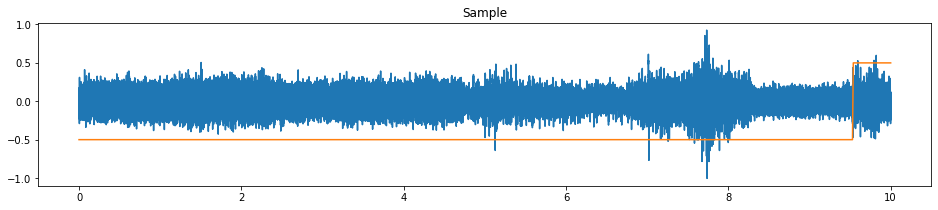

5 % voice 95 % silence


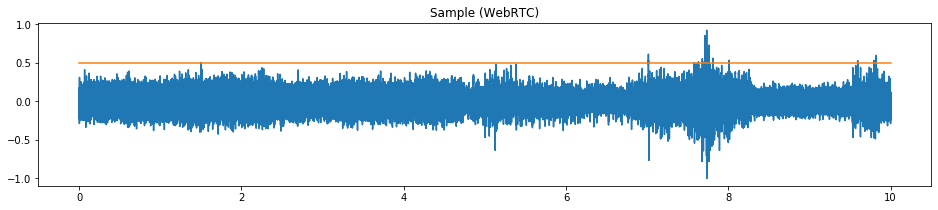

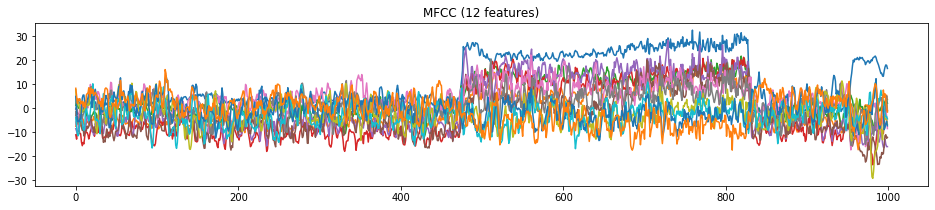

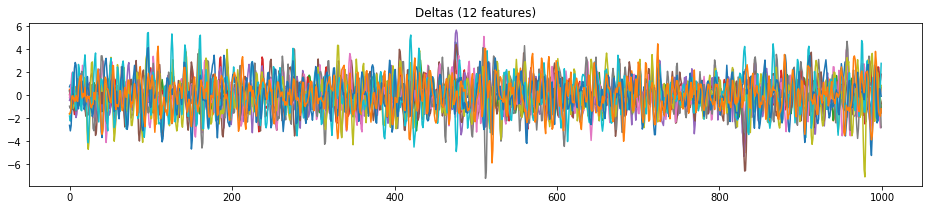

In [31]:
import matplotlib.pyplot as plt

class DataGenerator:
    
    def __init__(self, data, size_limit=0):        
        self.data = data
        self.size = size_limit if size_limit > 0 else len(data['labels'])
        self.data_mode = 0 # Default to training data
        
    def set_noise_level_db(self, level, reset_data_mode = True):
        
        if level not in noise_levels_db:
            raise Exception(f'Noise level "{level}" not supported! Options are: {list(noise_levels_db.keys())}')
        
        self.noise_level = level
        
        # Optionally reset data mode and position in file
        if reset_data_mode:
            if self.data_mode == 0:
                self.use_train_data()
            elif self.data_mode == 1:
                self.use_validate_data()
            elif self.data_mode == 2:
                self.use_test_data()
        
    def setup_generation(self, frame_count, step_size, batch_size, val_part=0.1, test_part=0.1):
        
        self.frame_count = frame_count
        self.step_size = step_size
        self.batch_size = batch_size
        
        # Setup indexes and sizes for data splits.
        self.train_index = 0
        self.val_index = int((1.0 - val_part - test_part) * self.size)
        self.test_index = int((1.0 - test_part) * self.size)
        
        self.train_size = self.val_index
        self.val_size = self.test_index - self.val_index
        self.test_size = self.size - self.test_index
        
    def use_train_data(self):
        
        # Calculate how many batches we can construct from our given parameters.
        n = int((self.train_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.train_index
        self.data_mode = 0
        
    def use_validate_data(self):
        
        # Calculate how many batches we can construct from our given parameters.
        n = int((self.val_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.val_index
        self.data_mode = 1
        
    def use_test_data(self):
        
        # Calculate how many batches we can construct from our given parameters.
        n = int((self.test_size - self.frame_count) / self.step_size) + 1
        self.batch_count = int(n / self.batch_size)
        self.initial_pos = self.test_index
        self.data_mode = 2

    def get_data(self, index_from, index_to):
        frames = self.data['frames-' + self.noise_level][index_from : index_to]
        mfcc = self.data['mfcc-' + self.noise_level][index_from : index_to]
        delta = self.data['delta-' + self.noise_level][index_from : index_to]
        labels = self.data['labels'][index_from : index_to]
        return frames, mfcc, delta, labels
        
    def get_batch(self, index):
        
        # Get current position.
        pos = self.initial_pos + (self.batch_size * index) * self.step_size
        
        # Get all data needed.
        l = self.frame_count + self.step_size * self.batch_size
        frames, mfcc, delta, labels = self.get_data(pos, pos + l)
        
        x, y, i = [], [], 0
        
        # Get batches
        while len(y) < self.batch_size:
            
            # Get data for the window. 
            X = np.hstack((mfcc[i : i + self.frame_count], delta[i : i + self.frame_count]))
            
            # Append sequence to list of frames
            x.append(X)
            
            # Select label from center of sequence as label for that sequence.
            y_range = labels[i : i + self.frame_count]
            y.append(int(y_range[int(self.frame_count / 2)]))
            
            # Increment window using set step size
            i += self.step_size
        
        return x, y
        
    def plot_data(self, index_from, index_to, show_track=False):
        
        frames, mfcc, delta, labels = self.get_data(index_from, index_to)
        
        Vis.plot_sample(frames, labels)
        Vis.plot_sample_webrtc(frames)
        Vis.plot_features(mfcc, delta)
        
        # By returning a track and having this as the last statement in a code cell,
        # the track will appear as an audio track UI element (not supported by Windows).
        if show_track and OBJ_SHOW_PLAYABLE_TRACKS:
            return (AudioSegment(data=array.array('h', frames.flatten()),
                                 sample_width=SAMPLE_WIDTH, frame_rate=SAMPLE_RATE, 
                                 channels=SAMPLE_CHANNELS))
        
# Test generator features.
generator = DataGenerator(data, size_limit=10000)

generator.setup_generation(frame_count=3, step_size=1, batch_size=2)
generator.set_noise_level_db('-3')
generator.use_train_data()
X, y = generator.get_batch(0)

print(f'Load a few frames into memory:\n{X[0]}\n\nCorresponding label: {y[0]}')

generator.plot_data(0, 1000)

In [38]:
BATCH_SIZE = 2048
FRAMES = 30
FEATURES = 24
STEP_SIZE = 6

In [48]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

lstm = LSTM1(2,24,30,2,24)


In [42]:
import torch.nn as nn

In [43]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=0)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
generator = DataGenerator(data, size_limit=10000)

generator.setup_generation(frame_count=3, step_size=1, batch_size=2)
generator.set_noise_level_db('-3')
generator.use_train_data()
X, y = generator.get_batch(0)

In [45]:
for i in range(3999):
    x,y = generator.get_batch(i)
    

3999

In [ ]:
train_net()

In [59]:
import torch.optim as optim
from IPython.display import clear_output
import time


def train_net(net, data, size_limit = 0, noise_level = 'None', epochs = 15, lr = 1e-3, use_adam = True,
              weight_decay = 1e-5, momentum = 0.9, use_focal_loss = True, gamma = 0.0,
              early_stopping = False, patience = 25, frame_count = FRAMES, step_size = STEP_SIZE,
              auto_save = True, title = 'net', verbose = True):
    '''
    Full-featured training of a given neural network.
    A number of training parameters are optionally adjusted.
    If verbose is True, the training progress is continously
    plotted at the end of each epoch.
    If auto_save is True, the model will be saved every epoch.
    '''
    
    # Set up an instance of data generator using default partitions
    generator = DataGenerator(data, size_limit)
    generator.setup_generation(frame_count, step_size, BATCH_SIZE)
    
    if noise_level not in ['None', '-15', '-3']:
        print('Error: invalid noise level!')
        return
    
    if generator.train_size == 0:
        print('Error: no training data was found!')
        return
    
    # Move network to GPU if available
    if OBJ_CUDA:
        net.cuda()
        
    # Instantiate the chosen loss function
    if use_focal_loss:
        criterion = FocalLoss(gamma)
        levels = ['None', '-15', '-3']
    else:
        criterion = nn.CrossEntropyLoss()
        levels = [noise_level]
        # Move criterion to GPU if available
    if OBJ_CUDA:
        criterion.cuda()
    
    # Instantiate the chosen optimizer with the parameters specified
    if use_adam:
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    # If verbose, print starting conditions
    if verbose:
        print(f'Initiating training of {title}...\n\nLearning rate: {lr}')
        _trsz = generator.train_size*3 if use_focal_loss else generator.train_size
        _vlsz = generator.val_size*3 if use_focal_loss else generator.val_size
        print(f'Model parameters: {sum(p.numel() for p in net.parameters())}')
        print(f'Frame partitions: {_trsz} | {_vlsz}')
        _critstr = f'Focal Loss (γ = {gamma})' if use_focal_loss else f'Cross-Entropy ({noise_level} dB)'
        _optmstr = f'Adam (decay = {weight_decay})' if use_adam else f'SGD (momentum = {momentum})'
        _earlstr = f'Early Stopping (patience = {patience})' if early_stopping else str(epochs)
        _autostr = 'Enabled' if auto_save else 'DISABLED'
        print(f'Criterion: {_critstr}\nOptimizer: {_optmstr}')
        print(f'Max epochs: {_earlstr}\nAuto-save: {_autostr}')
    
    net.train()
    stalecount, maxacc = 0, 0

In [60]:
train_net(lstm,data,noise_level='-3',gamma=2)

Initiating training of net...

Learning rate: 0.001
Model parameters: 18386
Frame partitions: 9320091 | 1165011
Criterion: Focal Loss (γ = 2)
Optimizer: Adam (decay = 1e-05)
Max epochs: 15
Auto-save: Enabled


In [63]:
from sklearn import metrics

def test_predict(net, data, size_limit, noise_level):
    '''
    Computes predictions on test data using given network.
    '''
    
    # Set up an instance of data generator using default partitions
    generator = DataGenerator(data, size_limit)
    generator.setup_generation(FRAMES, STEP_SIZE, BATCH_SIZE)
    
    if noise_level not in NOISE_LEVELS:
        print('Error: invalid noise level!')
        return
    
    if generator.test_size == 0:
        print('Error: no test data was found!')
        return
    
    net.eval()
    generator.use_test_data()
    generator.set_noise_level_db(noise_level)
    
    y_true, y_score = [], []

    for i in range(generator.batch_count):

        X, y = generator.get_batch(i)
        X = Variable(torch.from_numpy(np.array(X)).float())
        y = Variable(torch.from_numpy(np.array(y))).long()

        if OBJ_CUDA:
            X = X.cuda()

        out = net(X)

        if OBJ_CUDA:
            out = out.cpu()
            y = y.cpu()

        # Add true labels.
        y_true.extend(y.data.numpy())

        # Add probabilities for positive labels.
        y_score.extend(out.data.numpy()[:,1])
    
    return y_true, y_score

In [ ]:
test_predict()